# Analysis of representations learned by RelConvNet

## Set up

In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm, trange
from tqdm.keras import TqdmCallback
import argparse

import models
from setGame import SetGame
import data_utils

import sys; sys.path.append('../'); sys.path.append('../..')
import utils

2023-11-12 18:36:50.805511: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-12 18:36:50.852490: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-12 18:36:51.729959: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
setgame = SetGame()
_, set_labels, triples = setgame.generate_data()
set_triples = [triple for triple, is_set in zip(triples, set_labels) if is_set]

Total number of triples: 85320
Probability of SET! (in 85320 samples): 0.012658 (1/79=0.012658)


In [3]:
#region load data
# utils.print_section('LOADING DATA')

# get all possible triples and parition into SETs and non-SETs
# split set triples into train/val/test
setgame = SetGame()
_, set_labels, triples = setgame.generate_data()

set_triples = [triple for triple, is_set in zip(triples, set_labels) if is_set]
card_embedder = tf.keras.models.load_model('cnn_card_embedder/embedder')

Total number of triples: 85320
Probability of SET! (in 85320 samples): 0.012658 (1/79=0.012658)


2023-11-12 18:37:12.122145: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38375 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capability: 8.0


In [4]:
val_size = 0.15 #args.val_size
test_size = 0.15 #args.test_size

def train_val_test_split(X, val_size, test_size):
    from sklearn.model_selection import train_test_split
    X_train, X_test = train_test_split(X, test_size=test_size)
    X_train, X_val = train_test_split(X_train, test_size=val_size/(1-test_size))
    return X_train, X_val, X_test

set_triples_train, set_triples_val, set_triples_test = train_val_test_split(set_triples, val_size=val_size, test_size=test_size)

print(f'train SETs: {len(set_triples_train)}; val SETs: {len(set_triples_val)}; test SETs: {len(set_triples_test)}')


k = 5 # length of card sequence in wich to determine if a SET exists
_, _, labels_train, object_seqs_train = data_utils.create_set_classification_dataset(
    num_seqs=len(set_triples_train), k=k, set_triples=set_triples_train, card_embedder=card_embedder)
_, _, labels_val, object_seqs_val = data_utils.create_set_classification_dataset(
    num_seqs=len(set_triples_val), k=k, set_triples=set_triples_val, card_embedder=card_embedder)
_, _, labels_test, object_seqs_test = data_utils.create_set_classification_dataset(
    num_seqs=len(set_triples_test), k=k, set_triples=set_triples_test, card_embedder=card_embedder)

X_train, X_val, X_test = object_seqs_train, object_seqs_val, object_seqs_test
y_train, y_val, y_test = labels_train, labels_val, labels_test

train SETs: 756; val SETs: 162; test SETs: 162


2023-11-12 18:37:16.363332: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-12 18:37:16.609613: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [5]:

batch_size = 32 #args.batch_size
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)
#endregion

## Train Model

In [6]:
#region training setup
from tqdm.keras import TqdmCallback

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
create_opt = lambda: tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = ['acc']

def create_callbacks(data_size=None, batch_size=None):
    # callbacks = [
    #     wandb.keras.WandbMetricsLogger(log_freq='epoch')
    # ]
    callbacks = [TqdmCallback()]

    return callbacks

fit_kwargs = dict(epochs=100)
#endregion

In [7]:
train_size = -1 # args.train_size

#region functions
def train_model(
    create_model, eval_model, fit_kwargs, create_callbacks,
    train_ds, val_ds, test_ds, train_size
    ):

    model = create_model()

    train_ds_sample = train_ds.shuffle(buffer_size=len(train_ds)).take(train_size).batch(batch_size)
    history = model.fit(
        train_ds_sample, validation_data=val_ds, verbose=0,
        callbacks=create_callbacks(), **fit_kwargs)

    eval_dict = eval_model(model)

    return model, eval_dict
def eval_model(model):
    eval_metrics = model.evaluate(test_ds, return_dict=True, verbose=0)

    return eval_metrics

# endregion


In [8]:
#region train & evaluate model
def create_model():
    model = models.model_creators['relconvnet']()
    model.compile(loss=loss, optimizer=create_opt(), metrics=metrics) # compile
    model.build(input_shape=(None, *train_ds.element_spec[0].shape)) # build
    return model

In [9]:

# # utils.print_section("TRAINING & EVALUATING MODEL")
# model, eval_dict = train_model(
#     create_model, eval_model, fit_kwargs, create_callbacks,
#     train_ds, val_ds, test_ds, train_size
#     )
# #endregion

# model.save('models/relconvnet.keras')
# model.save('models/relconvnet.h5')
# model.save_weights('models/relconvnet_weights.h5')

## Analysis

In [10]:
model = create_model()
model.load_weights('models/relconvnet.h5')

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import sklearn.decomposition
import sklearn.manifold
import pandas as pd
import itertools

In [12]:
fsize = 8
tsize = 8
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
# plt.style.use('grid')
# plt.style.use('default')
# plt.rcParams['text.usetex'] = True
sns.set_style("whitegrid")
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

In [13]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")

In [14]:
vocab_size = 81
setgame = data_utils.setgame
dim = len(card_embedder(np.expand_dims(setgame.image_of_card(0, 0), axis=0)).numpy().squeeze())

# get embedding for each card
card_images = np.zeros((9, 9, dim))
for i in range(9):
    for j in range(9):
        card_images[i,j] = card_embedder(np.expand_dims(setgame.image_of_card(i, j), axis=0)).numpy().squeeze()

In [15]:
object_space = np.array([card_images[i,j] for i in range(9) for j in range(9)]).astype(float)
object_attrs = [setgame.attributes_of_card(i,j) for i in range(9) for j in range(9)]

In [16]:
obj_idx_space = list(itertools.product(range(9), repeat=2))
pair_idx_space = list(itertools.combinations(obj_idx_space, 2))
triplet_idx_space = list(itertools.combinations(obj_idx_space, 3))

In [17]:
# create space of combinations of two entities
pair_space = list(itertools.combinations(object_attrs, 2))

def attr_is_same(attr, x, y):
    return x[attr]==y[attr]

attr0_same = [attr_is_same(0, x, y) for (x,y) in pair_space]
attr1_same = [attr_is_same(1, x, y) for (x,y) in pair_space]
attr2_same = [attr_is_same(2, x, y) for (x,y) in pair_space]
attr3_same = [attr_is_same(3, x, y) for (x,y) in pair_space]

attr_sameness = np.array([attr0_same, attr1_same, attr2_same, attr3_same]).T

In [18]:
attr_map = {0: 'Number', 1: 'Color', 2: 'Fill', 3: 'Shape'}

def plot_encoder(encoder, axs, dim_red='pca'):

    encoded_entities = encoder(object_space)
    if dim_red=='pca':
        dim_red = sklearn.decomposition.PCA(n_components=2)
    elif dim_red=='tsne':
        dim_red = sklearn.manifold.TSNE(n_components=2, init='pca')
    else:
        raise ValueError('dim_red invalid')

    encoded_entities_2d = dim_red.fit_transform(encoded_entities)

    for attr, ax in zip(range(4), axs):
        attr_vals = np.array(object_attrs)[:, attr]

        # cmap = matplotlib.colors.ListedColormap(plt.get_cmap('Set1').colors[:3])
        plot_data = pd.DataFrame({'x': encoded_entities_2d[:,0], 'y': encoded_entities_2d[:, 1], 'attribute': attr_vals})
        sns.scatterplot(plot_data, x='x', y='y', hue='attribute', ax=ax)
        ax.set_xlabel('');ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.legend().set_visible(False)
        # sns.move_legend(ax, loc='upper right', title='Attribute')
        # scatter = ax.scatter(encoded_entities_2d[:,0], encoded_entities_2d[:, 1], c=attr_vals, cmap=cmap, s=50, alpha=0.5)
        # ax.set_title(f'{attr_map[attr]}')
        # legend = ax.legend(*scatter.legend_elements(),
        #                 loc="upper right", title="Attribute Values")
        # ax.add_artist(legend)


def plot_encoders(encoders, dim_red='pca',):
    '''plote each encoder's encodings against attributes via dimensionality reduction'''

    fig, axs = plt.subplots(ncols=4, nrows=len(encoders), figsize=(6, 1.25*len(encoders)))

    for i, encoder in enumerate(encoders):
        plot_encoder(encoder, axs[i], dim_red='pca')
        axs[i][0].set_ylabel(f'Encoder {i}')
        axs[i][0].set_ylabel(f'Encoder {i}')
    for attr in range(4):
        axs[0][attr].set_title(f'{attr_map[attr]}')

        sns.move_legend(axs[-1][attr], bbox_to_anchor=(0.5, -0.7), loc='lower center', title='')
    return fig


In [19]:
relconv_mdipr_encoders = model.get_layer('mhr1').left_encoders

In [20]:
# fig = plot_encoders(relconv_mdipr_encoders, dim_red='pca');

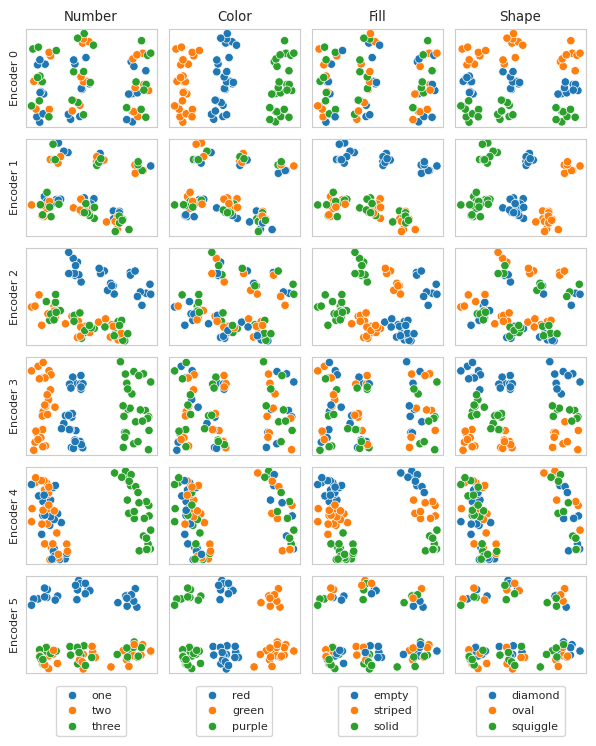

In [21]:
selection_idx = [
    1, # attr 1, attr 3
    # 5, # attr 1
    6, # attr 2, 3
    7, # attr 0, 2
    9, # attr 0, 3
    10, # 0, 2
    13, # 1
    # 15, # 1, 2
]
selected_relconv_mdipr_encoders = [relconv_mdipr_encoders[i] for i in selection_idx]
fig = plot_encoders(selected_relconv_mdipr_encoders, dim_red='pca');
fig.set_tight_layout(True)
fig.savefig('rep_analysis_figs/mdipr_encoders_rep.pdf')

In [22]:
def compute_pair_rels_1d(encoder):
    x1_enc = np.array([card_images[ent[0], ent[1]] for ent in np.array(pair_idx_space)[:, 0, :]]).astype(float)
    x2_enc = np.array([card_images[ent[0], ent[1]] for ent in np.array(pair_idx_space)[:, 1, :]]).astype(float)

    z1_enc = encoder(x1_enc).numpy()
    z2_enc = encoder(x2_enc).numpy()

    rels = np.array([np.inner(z1, z2) for (z1, z2) in zip(z1_enc, z2_enc)])

    return rels

def compute_pair_rels(encoders):
    '''computes relation vector induced by encoders for each pair of entities'''
    rels = np.stack([compute_pair_rels_1d(encoder) for encoder in encoders], axis=1)
    return rels

def plot_relation_attr_sameness(encoders, dim_red='pca', figsize=(8,2)):
    '''project relation vectors onto 2-d space then plate against sameness of each attr'''

    rels = compute_pair_rels(encoders)

    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=figsize)

    if dim_red=='pca':
        dim_red = sklearn.decomposition.PCA(n_components=2)
    elif dim_red=='tsne':
        dim_red = sklearn.manifold.TSNE(n_components=2, init='pca')
    else:
        raise ValueError('dim_red invalid')

    # for attr in range(attr_sameness.shape[1]):

    encoded_entities_2d = dim_red.fit_transform(rels)

    for attr, ax in zip(range(4), axs):
        attr_i_sameness = attr_sameness[:, attr]
        sameness_map = {0: 'different', 1: 'same'}
        attr_i_sameness = ['same' if x==1 else 'different' for x in attr_i_sameness]

        # cmap = matplotlib.colors.ListedColormap(plt.get_cmap('Set1').colors[:2])
        cmap = plt.get_cmap('Set1').colors[:2]
        plot_data = pd.DataFrame(dict(pc1=encoded_entities_2d[:,0], pc2=encoded_entities_2d[:,1]))
        plot_data['attr_sameness'] = pd.Categorical(attr_i_sameness, categories=['different', 'same'])
        sns.scatterplot(plot_data, x='pc1', y='pc2', hue='attr_sameness', alpha=0.7, palette=cmap, ax=ax, legend=True)
        # scatter = ax.scatter(encoded_entities_2d[:,0], encoded_entities_2d[:, 1], c=attr_i_sameness, cmap=cmap, s=50, alpha=0.5)
        # sns.move_legend(ax, loc='upper right', title='')
        ax.set_title(f'{attr_map[attr]}')
        ax.legend().set_visible(False)
        # legend = ax.legend(*scatter.legend_elements(),
                        # loc="upper right", title="")
        # ax.add_artist(legend)
        ax.set_xlabel('$R(x,y)$ [PC1]')
        ax.set_ylabel('')
    axs[0].set_ylabel('$R(x,y)$ [PC2]')
    sns.move_legend(axs[-1], loc='upper right')
    return fig

def rel_attr_pairplot(encoders):
    '''plots pairplot of relations against attribute samenss'''
    rels = compute_pair_rels(encoders)

    rels_df = pd.DataFrame(rels, columns=[f'rel_{i}' for i in range(rels.shape[1])])
    attr_sameness_df = pd.DataFrame(attr_sameness, columns=[f'attr_{i}_same' for i in range(attr_sameness.shape[1])])
    rels_sameness = rels_df.merge(attr_sameness_df, left_index=True, right_index=True)

    sns.pairplot(rels_sameness, x_vars=rels_df.columns, y_vars=attr_sameness_df.columns)#, corner=True)#, plot_kws={'alpha':0.05, 's': 25})


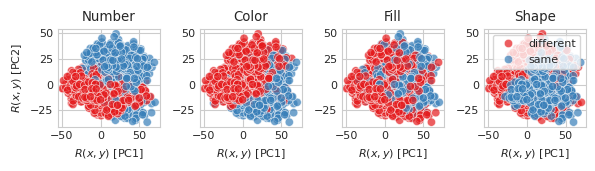

In [23]:
fig = plot_relation_attr_sameness(selected_relconv_mdipr_encoders, dim_red='pca', figsize=(6, 1.75));
fig.set_tight_layout(True)
fig.savefig('rep_analysis_figs/mdipr_rel_rep.pdf')

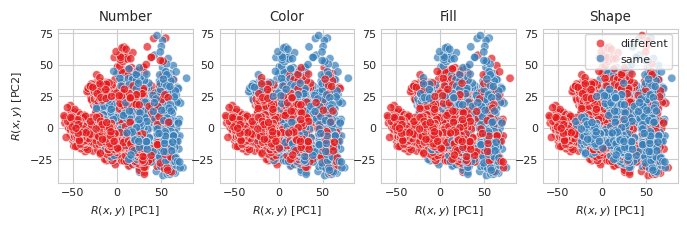

In [24]:
fig = plot_relation_attr_sameness(relconv_mdipr_encoders, dim_red='pca');

In [25]:
mdipr = model.get_layer('mhr1')
rgc = model.get_layer('rgc1')
filters = rgc.filters

In [26]:
x1_enc = np.array([card_images[ent[0], ent[1]] for ent in np.array(triples)[:, 0, :]])
x2_enc = np.array([card_images[ent[0], ent[1]] for ent in np.array(triples)[:, 1, :]])
x3_enc = np.array([card_images[ent[0], ent[1]] for ent in np.array(triples)[:, 2, :]])
triplets_enc = np.stack([x1_enc, x2_enc, x3_enc], axis=1)

In [27]:
triplets_rels = mdipr(triplets_enc)

In [28]:
triplets_rels.shape

TensorShape([85320, 3, 3, 16])

In [29]:
conv = rgc.rel_inner_prod(triplets_rels, filters)

In [30]:
conv.shape

TensorShape([85320, 16])

In [31]:
from imblearn.under_sampling import RandomUnderSampler

In [32]:
rus = RandomUnderSampler(random_state=0)
conv_rus, set_labels_rus = rus.fit_resample(conv, set_labels)

In [33]:
pca_conv = sklearn.decomposition.PCA(n_components=2).fit_transform(conv_rus)

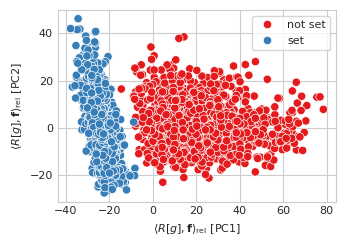

In [34]:
fig, ax = plt.subplots(figsize=(3.5,2.5))
conv_rep_df = pd.DataFrame({'conv [PC1]': pca_conv[:, 0], 'conv [PC2]': pca_conv[:,1]})
conv_rep_df['SET'] = pd.Categorical(['set' if x==1 else 'not set' for x in set_labels_rus])
cmap = plt.get_cmap('Set1').colors[:2]
sns.scatterplot(conv_rep_df, x='conv [PC1]', y='conv [PC2]', hue='SET', palette=cmap, ax=ax)
ax.set_xlabel(r"$\langle R[g], \mathbf{f} \rangle_{\mathrm{rel}}$ [PC1]");
ax.set_ylabel(r"$\langle R[g], \mathbf{f} \rangle_{\mathrm{rel}}$ [PC2]");
sns.move_legend(ax, loc='upper right', title='')
fig.set_tight_layout(True)
fig.savefig('rep_analysis_figs/conv_rep.pdf')

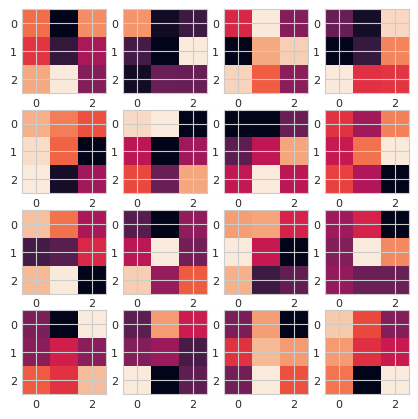

In [35]:
d_r = 9
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(5,5))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(filters[i,:, :, d_r])